# **Live video and features**


<div style="color:#777777;margin-top: -15px;">
<b>Author</b>: Norman Juchler |
<b>Course</b>: ADLS ISP |
<b>Version</b>: v1.2 <br><br>
<!-- v1.2, 23.04.2025: Refactored text -->
</div>

In this notebook, we'll take a closer look at detecting features in images – specific points or patterns that are informative and distinct, such as corners, edges, or blobs. These features are often used in tasks like image matching, motion tracking, or object recognition.

We'll focus on corner detection and edge detection, which are two fundamental approaches to identifying such features. To make the tutorial a bit more fun and interactive, we'll apply these techniques in real time using a live video feed from your webcam.


---

## **Preparations**

The usual preparations... The package `isp` provides some helper functions to easily render images in this Jupyter notebook.

To access certain advanced features, we need to make sure that the opencv-contrib-python package is installed.

In [1]:
import cv2
cv2.VideoCapture(0).release()


In [1]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal

# We need to install the OpenCV contrib package for some 
# advanced features (SIFT and SURF algorithms)
if not hasattr(cv, "xfeatures2d"):
    # !pip install opencv_contrib_python
    # Import the package again
    import importlib
    iportlib.reload(cv)

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Functionality related to this course
sys.path.append("..")
import isp

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

## **Exercise 1: Streaming a live video with OpenCV**

Displaying a live video stream from your webcam is fairly straightforward using OpenCV. To access and display a webcam video, we:
* Create a `cv.VideoCapture()` object to access the camera.
* Continuously read frames from the stream.
* Display each frame using a suitable method.

**Display the video:** Two approaches are shown below: one using `cv.imshow()` in a native window, and one for Jupyter notebooks using a *multithreaded* setup.

* Option 1: Display in a native window using `cv.imshow()`. This is the simplest way to display frames. It opens a separate window that updates with each new frame.
* Option 2: Display real-time video directly inside a Jupyter notebook. This is a bit more complex, as it requires a multithreaded setup*: One thread captures frames from the webcam. Another thread updates the display in the notebook. This approach gives us more flexibility, but is more sensitive to environment-specific limitations.

**Camera selection**: With the parameter `cam_id`, you can select which camera to use: 0 usually refers to the built-in webcam. 1 or higher refers to external or virtual cameras.

Accessing hardware devices such as cameras may not work in all Jupyter environments. This depends on system drivers and low-level access, which may be restricted. If you encounter problems, let me know or try running the script in a standalone Python environment instead.


### **Instructions:**

Read the following two examples and try whether your webcam works for real-time image processing.


### **Example 1: Display the video in a separate window**

In [2]:
def run_camera_cv(cam_id, 
                  window_name="Webcam", 
                  show_ontop=True,
                  width=640,
                  height=480,
                  flip=False, 
                  func=None, 
                  **kwargs):
    """Run a camera feed and display it using OpenCV.

    Args:
        cam_id (int): Camera ID (usually 0).
        window_name (str): Name of the window.
        width (int): Width of the window.
        height (int): Height of the window.
        flip (bool): Flip the image horizontally.
        func (function): Function to apply to the image.
        **kwargs: Keyword arguments for the function.
    """

    cap = cv.VideoCapture(cam_id)

    # Adjust the camera settings (may work, or not)
    cap.set(cv.CAP_PROP_FRAME_WIDTH, width)  # adjust width
    cap.set(cv.CAP_PROP_FRAME_HEIGHT, height)  # adjust height

    # Create named window
    cv.namedWindow(window_name, cv.WINDOW_AUTOSIZE)
    # Make the window always on top
    if show_ontop:
        cv.setWindowProperty(window_name, cv.WND_PROP_TOPMOST, 1)

    try:
        while True:
            # Read image from capturing device
            success, img = cap.read()
            if not success:
                break
            if flip:
                img = cv.flip(img, 1)
            if func is not None:
                # Modify image using the provided function
                img = func(img, **kwargs)
            # Display the image in the named window
            cv.imshow(window_name, img)
            # Wait and fetch for key input (the above window should be selected)
            key = cv.waitKey(1) & 0xFF
            # Quit if "q" or "Q" is pressed.
            if key in (ord("q"), ord("Q")): 
                cap.release()
                break

    except KeyboardInterrupt:
        pass
    finally:
        # We should always release the camera
        cap.release()
        # Comment out the following lines if you want to keep the window open
        cv.destroyAllWindows() 
        cv.waitKey(1)

In [3]:
####################
# Run demo
####################

# Choose the camera
cam_id = 0

# Window name
window_name = "Live Video"

# Flip the image
flip = True

# Run the camera!
run_camera_cv(cam_id, 
              window_name=window_name, 
              flip=flip)

### **Example 2: Display the video directly within the Jupyter notebook**

In [4]:
def run_camera_jupyter(cam_id=0, 
                       width=640,
                       height=480, 
                       frame_rate=0.1,
                       keep_last_frame=False,
                       func=None, 
                       **kwargs):
    """Run a camera feed and display it within Jupyter.
    
    It's nice to use this function with a Jupyter notebook, but it may be slow.

    Args: 
        cam_id: Camera ID (usually 0)
        width: Width of the image
        height: Height of the image
        frame_rate: Frame rate in frames per second
        keep_last_frame: Keep the last frame when stopping the camera
        func: Function to apply to the frame
        kwargs: Keyword arguments to pass to the function
    """

    from IPython.display import display, Image
    import ipywidgets as widgets
    import threading

    # Set up the stop button.
    stopButton = widgets.ToggleButton(
        value=False,
        description="Stop camera",
        disabled=False,
        button_style="info",  # 'success', 'info', 'warning', 'danger' or ''
        tooltip="Stop camera",
        icon="camera-retro",  # (FontAwesome names without the `fa-` prefix)
        #style=dict(font_weight="bold",)
    )

    # Display function
    import time
    def view(button):
        cap = cv.VideoCapture(cam_id)
        cap.set(cv.CAP_PROP_FRAME_WIDTH, width) # adjust width
        cap.set(cv.CAP_PROP_FRAME_HEIGHT, height) # adjust height
        
        display_handle=display(None, display_id=True)
        while True:
            _, frame = cap.read()
            frame = cv.flip(frame, 1) # if your camera reverses your image
            time.sleep(1/frame_rate)
            if frame is not None and frame.size != 0:
                if func is not None:
                    frame = func(frame, **kwargs)
                _, frame = cv.imencode(".jpeg", frame)
                image = Image(data=frame.tobytes(),
                              width=width, height=height)
                display_handle.update(image)
            if stopButton.value==True:
                print("Stopping video stream...")
                cap.release()
                if not keep_last_frame:
                    # Erase last frame
                    display_handle.update(None)
                    # Hide button
                    button.layout.visibility = "hidden"
                break
                
    # Run
    display(stopButton);
    thread = threading.Thread(target=view, args=(stopButton,));
    thread.start();


In [5]:

####################
# Settings
####################

# Choose the camera
cam_id = 0

# Jupyter cannot process too many frames per second...
frame_rate = 10

# Adjust width and height. Use None for screen-width
width = 800
#height = None

# Keep last frame alive
keep_last_frame = False

run_camera_jupyter(cam_id, 
                   width=width, 
                   frame_rate=frame_rate, 
                   keep_last_frame=keep_last_frame);

ToggleButton(value=False, button_style='info', description='Stop camera', icon='camera-retro', tooltip='Stop c…

None

Stopping video stream...


----

Using these functions, we can stream image frames from the camera and process them in real time.

To manipulate the video stream, you can provide a custom function via the `func` argument. This function should take a single frame as input and return the modified frame as output. Additional parameters for the function can be passed through the `kwargs` dictionary. Below is an example of a simple function that applies a blur filter to each frame.


In [6]:
def blur(img, kernel_size=5):
    """Blur an image using a Gaussian filter.
    """
    return cv.GaussianBlur(img, (kernel_size, kernel_size), 0) 

cam_id = 0
run_camera_cv(cam_id, 
              window_name="Demo: Blur",
              func=blur, kernel_size=105)


Alternatively, we can compute the amplitude spectrum of the image...

In [7]:
def fft(img):
    """Compute the FFT of an image.
    """
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Compute the FFT
    ft = scipy.fft.fft2(gray)
    ft = np.fft.fftshift(ft)
    ft_mag = np.log(np.abs(ft)+1)
    # ft_mag is float64. Normalize the image to [0,1]
    if ft_mag.max() > 0:
        ft_mag = ft_mag/ft_mag.max()
    #ft_mag = cv.normalize(ft_mag, None, 0, 1, cv.NORM_MINMAX)
    return ft_mag


run_camera_cv(cam_id, 
              window_name="Demo: Amplitude spectrum",
              func=fft)

---

<a id='exercise2'></a>

## **☆ Exercise 2: Canny edge detector**

In the previous notebook, you explored how to detect edges using the Canny edge detector. In this exercise, you'll apply the same technique to a live video stream from the camera.

### **Instructions:**

Adapt the demo code above to apply Canny edge detection to each frame of the webcam feed.

## Check out Solution of Norman for the Exams

In [ ]:
######################
###    EXERCISE    ###
######################


#thresholds decide what is / not / maybe an edge
#thr_upper pixel with gradient above this value = strong edge are kept
#thr_lower pixel with gradient lower are discarded = no edge 
# pixels between kept only if they're connected to strong edges
#goal is to have a balance between. If to high = image looks empty, to low = too much noise and messy picture
def canny(img, thr_lower = 100,thr_upper = 200):
    """ Apply Canny edge detection.
    """
    return cv.Canny(img,thr_lower, thr_upper)#explained underneath in the picture
    
cam_id = 0 #default, built in camera
run_camera_cv(cam_id, 
              window_name="Demo: Canny",#title of the video shown at the top
              func=canny)#the predefined func from above is used here



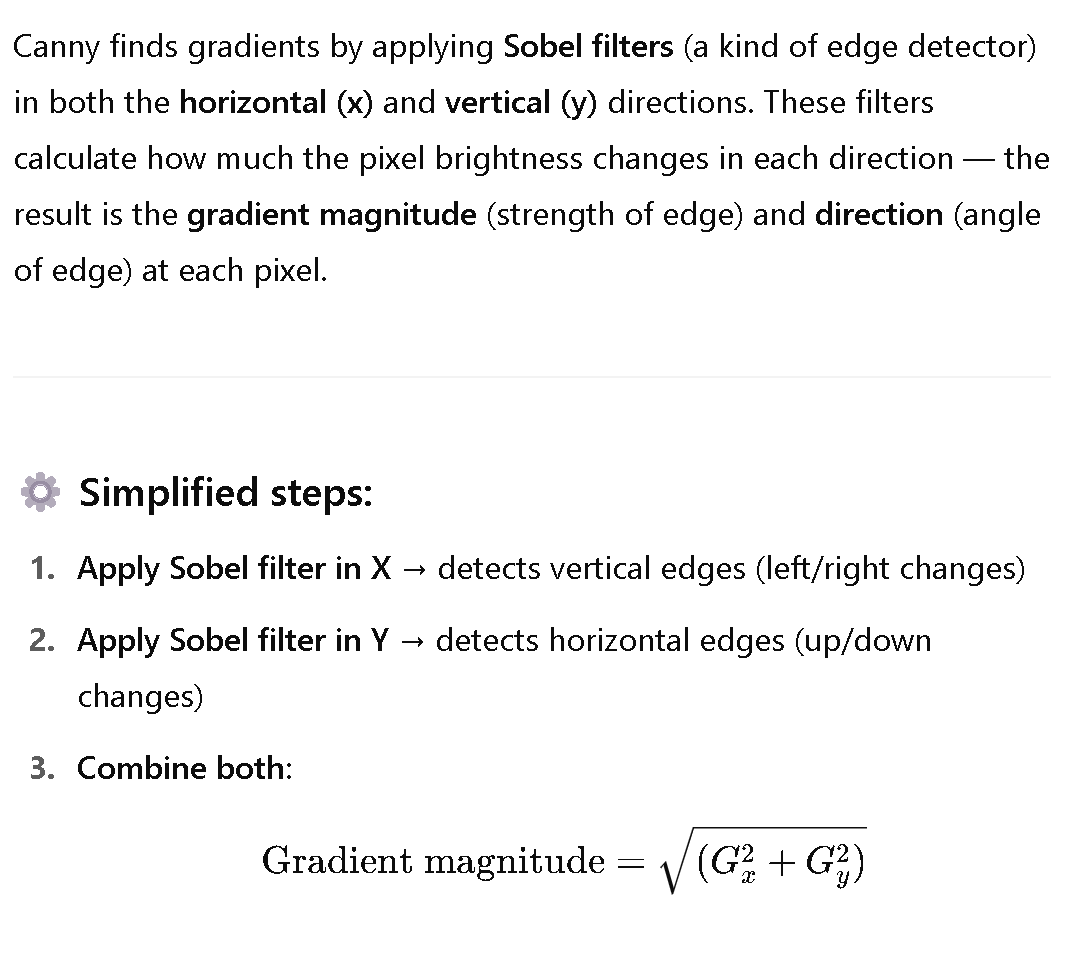

---

<a id='exercise3'></a>

## **☆ Exercise 3: Corner and blob features**

Corner and blob features are specific, easily recognizable points or regions in an image where the local appearance is distinct — for example, corners, junctions, or round blobs. These features are often used as keypoints for tracking, matching, or object recognition.

OpenCV provides a wide range of feature detectors, including both traditional and more advanced algorithms. In the lecture, we discussed the Scale-Invariant Feature Transform (SIFT), but there are also others such as the Harris corner detector, the Shi-Tomasi detector, the FAST detector, and more. The good news: OpenCV includes implementations of all of them, and their usage is quite similar.

### **Instructions:**

- Skim through the following overview of feature detection algorithms available in OpenCV: [Feature detection and description](https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html)
- Try out at least two different feature detectors and visualize their output using your webcam. If your webcam is not available, you can use a sample image from `../data/images`.

In [ ]:
######################
###    EXERCISE    ###
######################

def harris_corner(img, block_size=5, ksize=3, k=0.14):
    ...
    img = ...
    return img

run_camera_cv(cam_id=0,
              window_name="Harris corner detection",
              func=harris_corner)


...
...
...